# **Visualização dos Dados**


Lendo 8 arquivos...


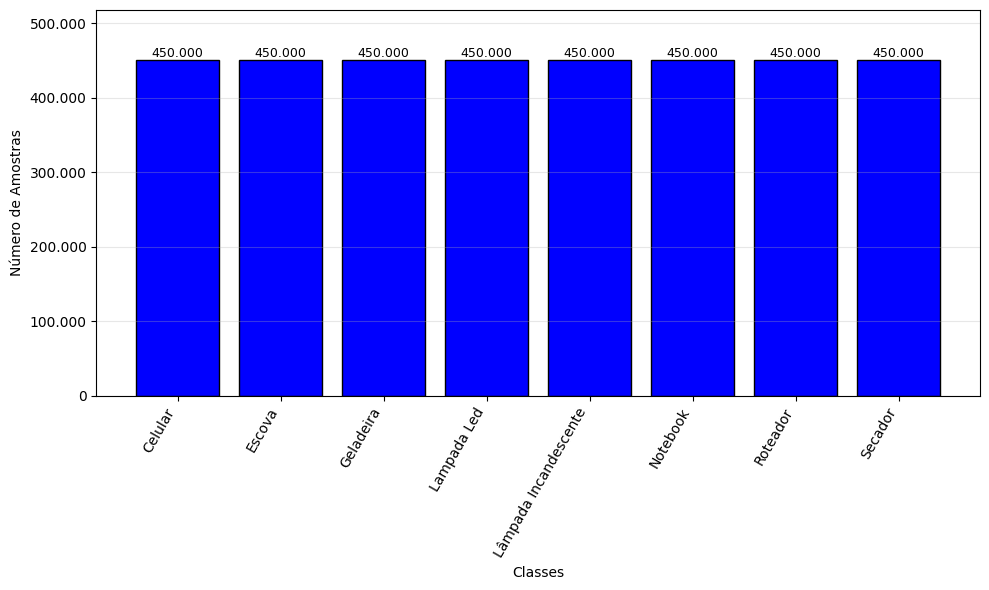

In [ ]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# --- CONFIGURAÇÃO GLOBAL DE CORES DE TEXTO ---
mpl.rcParams.update({
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
})

# --- CONFIGURAÇÃO DE NOMES ---
MAPA_DE_NOMES = {
    'Lamp Aquecimento': 'Lâmpada Incandescente',
    'Lamp Led': 'Lâmpada LED',
    'Secador De Cabelo': 'Secador',
    'Ar Condicionado': 'Ar Condicionado',
    'Microondas': 'Micro-ondas',
}


def contar_linhas_rapido(caminho):
    with open(caminho, 'rb') as f:
        return sum(1 for _ in f) - 1


def obter_dados(padrao_arquivos):
    registros = []
    arquivos = glob.glob(padrao_arquivos)

    if not arquivos:
        return pd.DataFrame({
            'classe': ['Celular', 'Escova de Cabelo', 'Geladeira', 'Lamp Aquecimento', 'Lamp LED', 'Notebook', 'Roteador', 'Secador De Cabelo'],
            'quantidade': [450000] * 8
        })

    print(f"Lendo {len(arquivos)} arquivos...")
    for path in arquivos:
        nome_bruto = os.path.basename(path).replace('_tempo.csv', '').replace('_', ' ').title()
        nome_final = MAPA_DE_NOMES.get(nome_bruto, nome_bruto)
        n = contar_linhas_rapido(path)
        registros.append((nome_final, n))

    df = pd.DataFrame(registros, columns=['classe', 'quantidade'])
    return df.sort_values('classe').reset_index(drop=True)


def plot_final(df, save_path='distribuicao_final.pdf'):
    plt.figure(figsize=(10, 6))

    # Barras
    barras = plt.bar(df['classe'], df['quantidade'],
                     color='blue', edgecolor='black', linewidth=1.0)

    # Ticks do eixo x
    plt.xticks(rotation=60, ha='right', fontsize=10, color='black')
    plt.yticks(color='black')

    plt.xlabel('Classes', color='black')
    plt.ylabel('Número de Amostras', color='black')
    # plt.title('Distribuição de Amostras', color='black')  # Opcional

    # Grid
    plt.grid(True, alpha=0.3, axis='y')

    # Formatação (pontos de milhar)
    plt.gca().yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', '.'))
    )

    # Valores no topo
    y_max = df['quantidade'].max()
    plt.ylim(0, y_max * 1.15)

    for rect in barras:
        height = rect.get_height()
        plt.text(
            rect.get_x() + rect.get_width()/2.0,
            height,
            f'{int(height):,}'.replace(',', '.'),
            ha='center',
            va='bottom',
            fontsize=9,
            color='black'
        )

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# --- Execução ---
if __name__ == '__main__':
    padrao = '*_tempo.csv'
    df = obter_dados(padrao)
    plot_final(df)


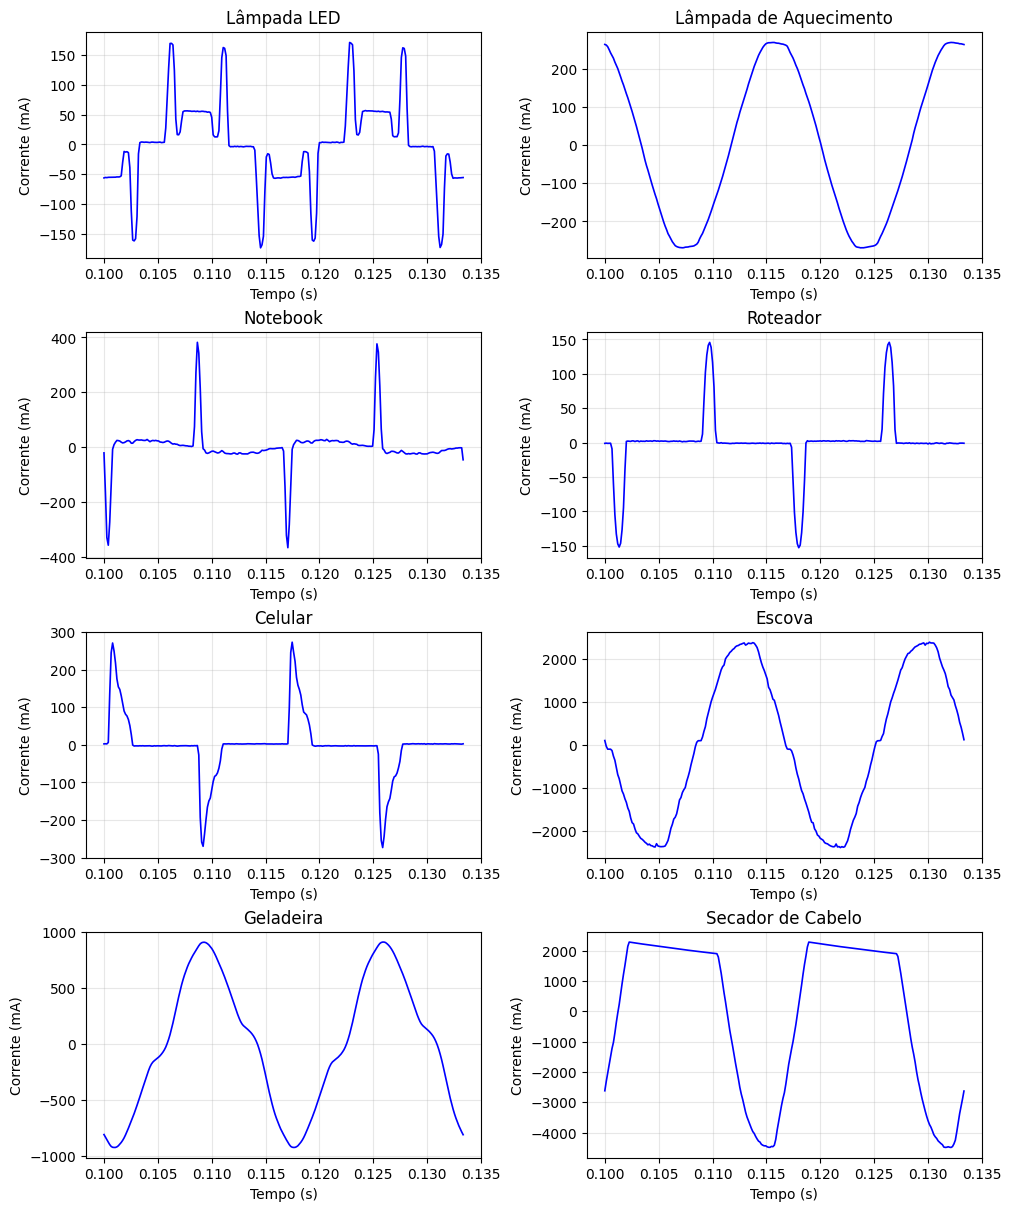

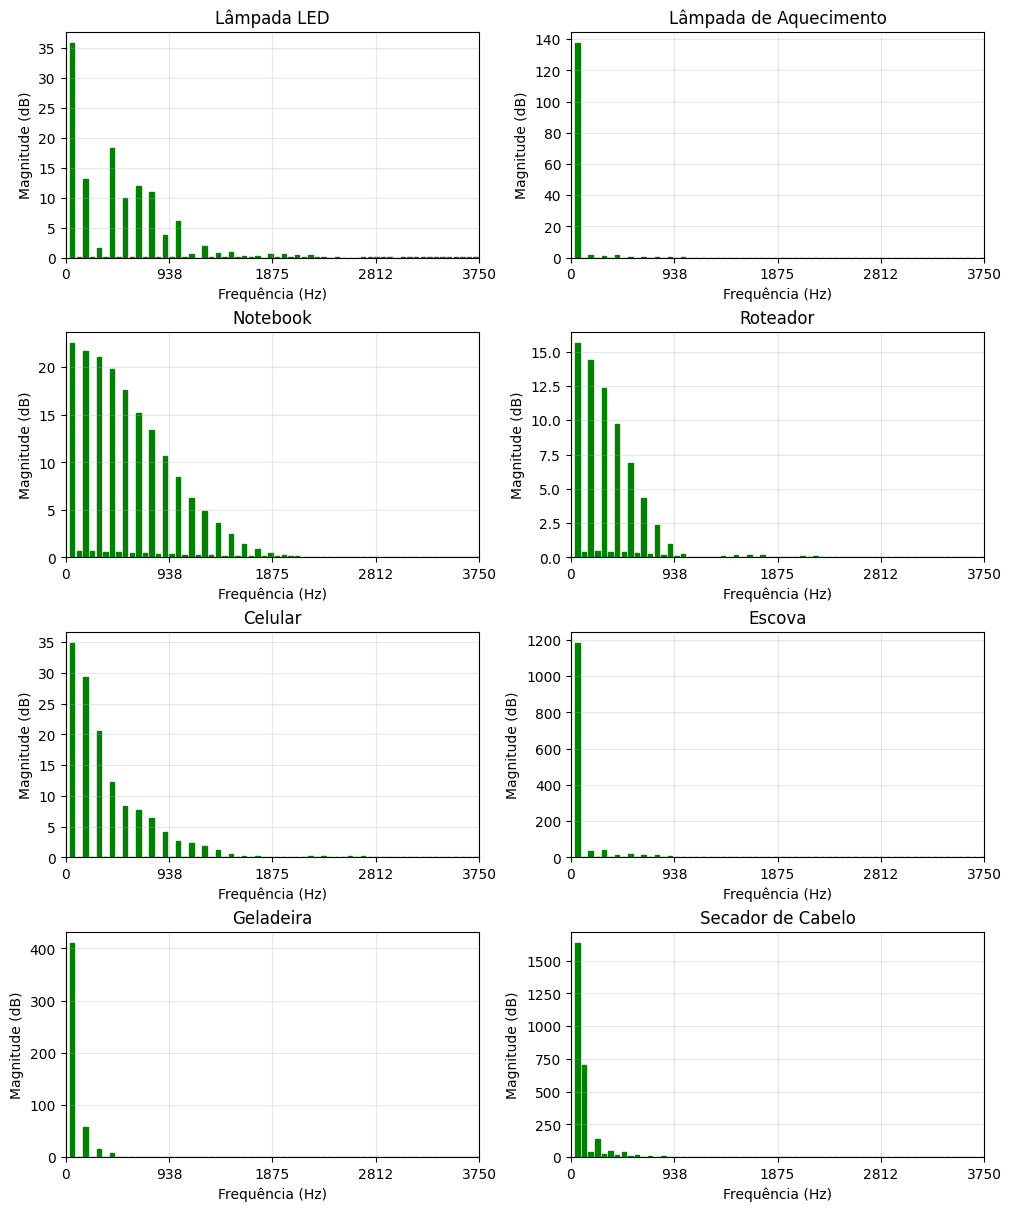

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

def get_data_tempo(path_csv, fs, t_min=0.0):
    try:
        df = pd.read_csv(path_csv, header=0)
        corrente = df.iloc[:, 1].astype(float).values

        N = min(len(corrente), fs)
        corrente = corrente[:N]
        t = np.arange(N) / fs

        f_rede = 60.0
        T2 = 2.0 / f_rede
        t_max = t_min + T2
        mask = (t >= t_min) & (t <= t_max)

        return t[mask], corrente[mask]
    except FileNotFoundError:
        print(f"Aviso: {path_csv} não encontrado.")
        return None, None

def get_data_freq(path_csv, fs):
    try:
        df = pd.read_csv(path_csv, header=0)
        corrente = df.iloc[:, 1].astype(float).values

        N = min(len(corrente), fs)
        corrente = corrente[:N]

        fft_vals = np.fft.rfft(corrente)

        # Cálculo da Magnitude Linear (escala proporcional a mA)
        # Se quisesse dB, teria que aplicar 20*log10 aqui.
        mag = np.abs(fft_vals) / N

        freqs = np.fft.rfftfreq(N, d=1/fs)

        f_rede = 60.0
        max_freq = 3750.0
        harm = np.arange(f_rede, max_freq + f_rede, f_rede)
        harm = harm[harm <= max_freq]

        idx = [np.argmin(np.abs(freqs - fh)) for fh in harm]
        mag_harm = mag[idx]

        return harm, mag_harm, max_freq
    except FileNotFoundError:
        print(f"Aviso: {path_csv} não encontrado.")
        return None, None, None

# --- Configurações ---
fs = 7500
t_min_padrao = 0.10

arquivos_titulos = {
    'Lampada_led_tempo.csv':         'Lâmpada LED',
    'lamp_aquecimento_tempo.csv':    'Lâmpada de Aquecimento',
    'notebook_tempo.csv':            'Notebook',
    'roteador_tempo.csv':            'Roteador',
    'celular_tempo.csv':             'Celular',
    'escova_tempo.csv':              'Escova',
    'geladeira_tempo.csv':           'Geladeira',
    'secador_de_cabelo_tempo.csv':   'Secador de Cabelo'
}

files_list = list(arquivos_titulos.keys())
titles_list = list(arquivos_titulos.values())
n_plots = len(files_list)
cols = 2
rows = math.ceil(n_plots / cols)

# =============================================================================
# 1. DOMÍNIO DO TEMPO
# =============================================================================
fig, axes = plt.subplots(rows, cols, figsize=(10, 12), constrained_layout=True)
axes_flat = axes.flatten()

for i, ax in enumerate(axes_flat):
    if i < n_plots:
        csv_file = files_list[i]
        title = titles_list[i]
        t, y = get_data_tempo(csv_file, fs, t_min=t_min_padrao)

        if t is not None:
            ax.plot(t, y, color='blue', linewidth=1.2)
            ax.set_title(title, fontsize=12, fontweight='normal')
            ax.grid(True, alpha=0.3)

            # Eixos em todos os gráficos
            ax.set_xlabel('Tempo (s)', fontsize=10)
            ax.set_ylabel('Corrente (mA)', fontsize=10)
        else:
            ax.text(0.5, 0.5, 'Dados não encontrados', ha='center')
    else:
        ax.axis('off')

plt.savefig('todos_tempo_conjunto.pdf', dpi=300)
plt.show()

# =============================================================================
# 2. DOMÍNIO DA FREQUÊNCIA
# =============================================================================
fig, axes = plt.subplots(rows, cols, figsize=(10, 12), constrained_layout=True)
axes_flat = axes.flatten()

for i, ax in enumerate(axes_flat):
    if i < n_plots:
        csv_file = files_list[i]
        title = titles_list[i]
        harm, mag, max_f = get_data_freq(csv_file, fs)

        if harm is not None:
            ax.bar(harm, mag, width=40, color='green', edgecolor='green')
            ax.set_xlim(0, max_f)
            xticks = np.linspace(0, max_f, 5)
            ax.set_xticks(xticks)

            ax.set_title(title, fontsize=12, fontweight='normal')
            ax.grid(True, alpha=0.3)

            # Eixos em todos os gráficos
            ax.set_xlabel('Frequência (Hz)', fontsize=10)

            # Rótulo ajustado para Magnitude (Escala Linear)
            ax.set_ylabel('Magnitude (dB)', fontsize=10)
        else:
             ax.text(0.5, 0.5, 'Dados não encontrados', ha='center')
    else:
        ax.axis('off')

plt.savefig('todos_freq_conjunto.pdf', dpi=300)
plt.show()

# **Pré-processamento**

In [3]:
import numpy as np
import pandas as pd
from glob import glob
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ---------------------
# Parâmetros principais
# ---------------------
fs = 7500                 # Hz (frequência de amostragem)
f_rede = 60               # Hz (apenas referência)
samples_per_cycle = int(fs / f_rede)  # ~125 amostras por ciclo
window_size = samples_per_cycle      # tamanho da janela em amostras (1 ciclo)
step = samples_per_cycle // 5        # passo da janela (20% do tamanho -> 80% overlap)
n_harmonics = 15                     # quantos harmônicos salvar da FFT

# comprimento da sequência de janelas para a LSTM (ex.: 5 ciclos)
L_seq = 5

# ---------------------
# Funções auxiliares
# ---------------------

def window_signal(sig, window_size, step):
    """Gera janelas deslizantes de um vetor 1D."""
    n = len(sig)
    if n < window_size:
        return np.empty((0, window_size))
    idx_start = np.arange(0, n - window_size + 1, step)
    windows = np.stack([sig[i:i + window_size] for i in idx_start])
    return windows

def zero_crossings(x):
    """Conta cruzamentos por zero em uma janela."""
    return np.sum(np.diff(np.signbit(x)) != 0)

def time_features(win):
    """Extrai features de tempo de uma janela 1D."""
    x = win
    mean = np.mean(x)
    std = np.std(x)
    rms = np.sqrt(np.mean(x**2))
    peak = np.max(np.abs(x))
    crest_factor = peak / (rms + 1e-12)
    var = np.var(x)
    kur = kurtosis(x)
    sk = skew(x)
    zc = zero_crossings(x)
    return np.array([mean, std, rms, peak, crest_factor, var, kur, sk, zc])

def freq_features(win, fs, n_harmonics,
                  f_min=40.0, f_max=80.0,
                  band_width_hz=5.0):
    """
    Extrai features de frequência (harmônicos + THD) de uma janela,
    com:
      - detecção automática da fundamental (pico em [f_min, f_max])
      - integração de energia em bandas em torno de cada harmônico.
    """
    N = len(win)
    if N == 0:
        return np.zeros(n_harmonics + 1, dtype=float)

    # janela de Hann e FFT
    win_hann = win * np.hanning(N)
    fft_vals = np.fft.rfft(win_hann)
    mag = np.abs(fft_vals) / (N / 2.0)
    freqs = np.fft.rfftfreq(N, d=1.0/fs)

    # passo em frequência (aprox. fs/N)
    df = freqs[1] - freqs[0]

    # -------------------------
    # 1) Detectar a fundamental
    # -------------------------
    # limitar busca a [f_min, f_max]
    mask_fund = (freqs >= f_min) & (freqs <= f_max)
    if not np.any(mask_fund):
        # fallback: devolve zeros se não tiver nada no range
        return np.zeros(n_harmonics + 1, dtype=float)

    mag_fund_zone = mag[mask_fund]
    freqs_fund_zone = freqs[mask_fund]

    # índice do pico local na zona [f_min, f_max]
    local_idx = np.argmax(mag_fund_zone)
    f0 = freqs_fund_zone[local_idx]   # frequência fundamental estimada

    # índice global correspondente ao pico
    fundamental_idx = np.argmin(np.abs(freqs - f0))

    # largura de banda em número de bins
    half_bw_bins = max(1, int(np.round(band_width_hz / df / 2.0)))

    harm_mag = []
    harm_energy = []

    # -----------------------------------
    # 2) Integrar energia em cada harmônico
    # -----------------------------------
    for k in range(1, n_harmonics + 1):
        center_freq = k * f0
        if center_freq > freqs[-1]:
            harm_mag.append(0.0)
            harm_energy.append(0.0)
            continue

        center_idx = int(np.round(center_freq / df))
        idx_start = max(0, center_idx - half_bw_bins)
        idx_end   = min(len(mag) - 1, center_idx + half_bw_bins)

        band_mags = mag[idx_start:idx_end+1]
        # amplitude média na banda
        harm_mag.append(np.mean(band_mags))
        # energia (potência ~ mag^2) integrada
        harm_energy.append(np.sum(band_mags**2))

    harm_mag = np.array(harm_mag)
    harm_energy = np.array(harm_energy)

    # -------------------------
    # 3) THD usando energias
    # -------------------------
    if harm_energy[0] > 0:
        thd = np.sqrt(np.sum(harm_energy[1:])) / np.sqrt(harm_energy[0])
    else:
        thd = 0.0

    return np.concatenate([harm_mag, np.array([thd])])

def extract_features_from_windows(windows, fs, n_harmonics):
    """Retorna matriz [num_janelas, num_features] com tempo+freq."""
    if windows.shape[0] == 0:
        return np.empty((0, 0))
    feats_time = np.apply_along_axis(time_features, 1, windows)
    feats_freq = np.apply_along_axis(freq_features, 1, windows, fs, n_harmonics)
    return np.hstack([feats_time, feats_freq])

def split_signal_timewise(sig, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Divide o vetor em três blocos consecutivos: treino, val, teste."""
    n = len(sig)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    n_test = n - n_train - n_val
    sig_train = sig[0:n_train]
    sig_val   = sig[n_train:n_train + n_val]
    sig_test  = sig[n_train + n_val:]
    return sig_train, sig_val, sig_test

def build_sequences(wins, labels, L):
    """
    wins:   [N_w, T]
    labels: [N_w]
    Retorna:
        X_seq: [N_seq, L, T]
        y_seq: [N_seq]
    """
    if len(wins) < L:
        return np.empty((0, L, wins.shape[1])), np.empty((0,), dtype=labels.dtype)
    X_seq = []
    y_seq = []
    for i in range(0, len(wins) - L + 1):
        X_seq.append(wins[i:i+L])       # sequência de L janelas
        y_seq.append(labels[i+L-1])     # rótulo da última janela
    return np.array(X_seq), np.array(y_seq)

# ---------------------
# Acumuladores globais
# ---------------------

X_raw_train_list, X_tf_train_list, y_train_list = [], [], []
X_raw_val_list,   X_tf_val_list,   y_val_list   = [], [], []
X_raw_test_list,  X_tf_test_list,  y_test_list  = [], [], []

# acumuladores específicos para LSTM (sequências)
X_lstm_train_list, y_lstm_train_list = [], []
X_lstm_val_list,   y_lstm_val_list   = [], []
X_lstm_test_list,  y_lstm_test_list  = [], []

# ---------------------
# Loop sobre arquivos
# ---------------------

all_files = sorted(glob('*_tempo.csv'))
print('Arquivos encontrados:', all_files)

for path in all_files:
    label = path.replace('_tempo.csv', '')
    print(f'Processando {path} (label = {label})')

    # lê coluna de corrente (segunda coluna)
    df = pd.read_csv(path, header=0, usecols=[1])
    data = df.iloc[:, 0].astype(float).values

    # divide o sinal em 3 blocos de tempo
    sig_train, sig_val, sig_test = split_signal_timewise(data)

    # gera janelas para cada bloco (sem cruzar blocos)
    wins_train = window_signal(sig_train, window_size, step)
    wins_val   = window_signal(sig_val,   window_size, step)
    wins_test  = window_signal(sig_test,  window_size, step)

    # extrai features tempo+freq
    feats_train = extract_features_from_windows(wins_train, fs, n_harmonics)
    feats_val   = extract_features_from_windows(wins_val,   fs, n_harmonics)
    feats_test  = extract_features_from_windows(wins_test,  fs, n_harmonics)

    # rótulos por janela
    y_train_block = np.full(wins_train.shape[0], label)
    y_val_block   = np.full(wins_val.shape[0],   label)
    y_test_block  = np.full(wins_test.shape[0],  label)

    # acumula janelas/feats (para kNN/SVM/CNN)
    if wins_train.shape[0] > 0:
        X_raw_train_list.append(wins_train)
        X_tf_train_list.append(feats_train)
        y_train_list.append(y_train_block)

    if wins_val.shape[0] > 0:
        X_raw_val_list.append(wins_val)
        X_tf_val_list.append(feats_val)
        y_val_list.append(y_val_block)

    if wins_test.shape[0] > 0:
        X_raw_test_list.append(wins_test)
        X_tf_test_list.append(feats_test)
        y_test_list.append(y_test_block)

    # ---------------------
    # Sequências para LSTM
    # ---------------------
    if wins_train.shape[0] > 0:
        X_seq_tr, y_seq_tr = build_sequences(wins_train, y_train_block, L_seq)
        if X_seq_tr.shape[0] > 0:
            X_lstm_train_list.append(X_seq_tr)
            y_lstm_train_list.append(y_seq_tr)

    if wins_val.shape[0] > 0:
        X_seq_val, y_seq_val = build_sequences(wins_val, y_val_block, L_seq)
        if X_seq_val.shape[0] > 0:
            X_lstm_val_list.append(X_seq_val)
            y_lstm_val_list.append(y_seq_val)

    if wins_test.shape[0] > 0:
        X_seq_te, y_seq_te = build_sequences(wins_test, y_test_block, L_seq)
        if X_seq_te.shape[0] > 0:
            X_lstm_test_list.append(X_seq_te)
            y_lstm_test_list.append(y_seq_te)

# ---------------------
# Empilhar tudo (janelas)
# ---------------------

X_raw_train = np.vstack(X_raw_train_list)
X_tf_train  = np.vstack(X_tf_train_list)
y_text_train = np.concatenate(y_train_list)

X_raw_val = np.vstack(X_raw_val_list)
X_tf_val  = np.vstack(X_tf_val_list)
y_text_val = np.concatenate(y_val_list)

X_raw_test = np.vstack(X_raw_test_list)
X_tf_test  = np.vstack(X_tf_test_list)
y_text_test = np.concatenate(y_test_list)

print('Shapes brutos (janelas):')
print('Treino ->', X_raw_train.shape, X_tf_train.shape, y_text_train.shape)
print('Val    ->', X_raw_val.shape,   X_tf_val.shape,   y_text_val.shape)
print('Teste  ->', X_raw_test.shape,  X_tf_test.shape,  y_text_test.shape)

# ---------------------
# Empilhar tudo (sequências LSTM)
# ---------------------

X_lstm_train_raw = np.vstack(X_lstm_train_list)   # [N_seq_tr, L_seq, 125]
y_text_lstm_train = np.concatenate(y_lstm_train_list)

X_lstm_val_raw   = np.vstack(X_lstm_val_list)
y_text_lstm_val  = np.concatenate(y_lstm_val_list)

X_lstm_test_raw  = np.vstack(X_lstm_test_list)
y_text_lstm_test = np.concatenate(y_lstm_test_list)

print('Shapes brutos LSTM (sequências):')
print('Treino ->', X_lstm_train_raw.shape, y_text_lstm_train.shape)
print('Val    ->', X_lstm_val_raw.shape,   y_text_lstm_val.shape)
print('Teste  ->', X_lstm_test_raw.shape,  y_text_lstm_test.shape)

# ---------------------
# Codificação de rótulos
# ---------------------

le = LabelEncoder()
y_train = le.fit_transform(y_text_train)
y_val   = le.transform(y_text_val)
y_test  = le.transform(y_text_test)

# rótulos para as sequências da LSTM, usando o mesmo encoder
y_train_lstm = le.transform(y_text_lstm_train)
y_val_lstm   = le.transform(y_text_lstm_val)
y_test_lstm  = le.transform(y_text_lstm_test)

# ---------------------
# Normalização das features (kNN/SVM)
# ---------------------

scaler_tf = StandardScaler()
X_train_knn = scaler_tf.fit_transform(X_tf_train)
X_val_knn   = scaler_tf.transform(X_tf_val)
X_test_knn  = scaler_tf.transform(X_tf_test)

# ---------------------
# Normalização das janelas cruas (CNN) - z-score por janela
# ---------------------

def normalize_windows_per_sample(X_raw):
    mean = X_raw.mean(axis=1, keepdims=True)
    std = X_raw.std(axis=1, keepdims=True) + 1e-12
    return (X_raw - mean) / std

X_train_raw_norm = normalize_windows_per_sample(X_raw_train)
X_val_raw_norm   = normalize_windows_per_sample(X_raw_val)
X_test_raw_norm  = normalize_windows_per_sample(X_raw_test)

# formatos finais [N, T, 1] para CNN
X_train_cnn = X_train_raw_norm[..., np.newaxis]
X_val_cnn   = X_val_raw_norm[..., np.newaxis]
X_test_cnn  = X_test_raw_norm[..., np.newaxis]

# ---------------------
# Normalização das sequências para LSTM
# ---------------------

def normalize_seq_per_window(X_seq):
    """
    X_seq: [N_seq, L_seq, T]
    Normaliza cada janela (eixo T) individualmente (z-score).
    """
    N_seq, L, T = X_seq.shape
    X_flat = X_seq.reshape(-1, T)           # [N_seq*L, T]
    X_flat_norm = normalize_windows_per_sample(X_flat)
    return X_flat_norm.reshape(N_seq, L, T)

X_train_lstm_norm = normalize_seq_per_window(X_lstm_train_raw)
X_val_lstm_norm   = normalize_seq_per_window(X_lstm_val_raw)
X_test_lstm_norm  = normalize_seq_per_window(X_lstm_test_raw)

# formatos finais para LSTM: [N_seq, L_seq, T]
X_train_lstm = X_train_lstm_norm
X_val_lstm   = X_val_lstm_norm
X_test_lstm  = X_test_lstm_norm

print('Shapes finais:')
print('kNN/SVM ->',
      'train:', X_train_knn.shape,
      'val:',   X_val_knn.shape,
      'test:',  X_test_knn.shape)

print('CNN     ->',
      'train:', X_train_cnn.shape,
      'val:',   X_val_cnn.shape,
      'test:',  X_test_cnn.shape)

print('LSTM    ->',
      'train:', X_train_lstm.shape,
      'val:',   X_val_lstm.shape,
      'test:',  X_test_lstm.shape)

print('Labels  ->',
      'train:', y_train.shape,
      'val:',   y_val.shape,
      'test:',  y_test.shape)


Arquivos encontrados: ['Lampada_led_tempo.csv', 'celular_tempo.csv', 'escova_tempo.csv', 'geladeira_tempo.csv', 'lamp_aquecimento_tempo.csv', 'notebook_tempo.csv', 'roteador_tempo.csv', 'secador_de_cabelo_tempo.csv']
Processando Lampada_led_tempo.csv (label = Lampada_led)
Processando celular_tempo.csv (label = celular)
Processando escova_tempo.csv (label = escova)
Processando geladeira_tempo.csv (label = geladeira)
Processando lamp_aquecimento_tempo.csv (label = lamp_aquecimento)
Processando notebook_tempo.csv (label = notebook)
Processando roteador_tempo.csv (label = roteador)
Processando secador_de_cabelo_tempo.csv (label = secador_de_cabelo)
Shapes brutos (janelas):
Treino -> (100768, 125) (100768, 25) (100768,)
Val    -> (21568, 125) (21568, 25) (21568,)
Teste  -> (21568, 125) (21568, 25) (21568,)
Shapes brutos LSTM (sequências):
Treino -> (100736, 5, 125) (100736,)
Val    -> (21536, 5, 125) (21536,)
Teste  -> (21536, 5, 125) (21536,)
Shapes finais:
kNN/SVM -> train: (100768, 25) v

In [4]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow import keras
from tensorflow.keras import layers

# ---------------------------------------------
# Codificação one-hot (depois do LabelEncoder)
# ---------------------------------------------
num_classes = len(np.unique(y_train))

# janelas individuais (kNN/SVM/CNN)
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_val_cat   = keras.utils.to_categorical(y_val,   num_classes)
y_test_cat  = keras.utils.to_categorical(y_test,  num_classes)

# sequências LSTM
y_train_lstm_cat = keras.utils.to_categorical(y_train_lstm, num_classes)
y_val_lstm_cat   = keras.utils.to_categorical(y_val_lstm,   num_classes)
y_test_lstm_cat  = keras.utils.to_categorical(y_test_lstm,  num_classes)

# =================================================
#              TREINAMENTO DOS MODELOS
# =================================================

# -------------------------------------------------
# 1) kNN
# -------------------------------------------------
print('\n=== kNN ===')

knn = KNeighborsClassifier(
    n_neighbors=5,
    metric='euclidean',
    weights='distance'
)
knn.fit(X_train_knn, y_train)

y_pred_knn = knn.predict(X_test_knn)
print('Acurácia kNN:', accuracy_score(y_test, y_pred_knn))
print('\nRelatório de classificação (kNN):')
print(classification_report(y_test, y_pred_knn))
print('\nMatriz de confusão (kNN):')
print(confusion_matrix(y_test, y_pred_knn))

# -------------------------------------------------
# 2) SVM (RBF)
# -------------------------------------------------
print('\n=== SVM (RBF) ===')

svm_clf = SVC(
    kernel='rbf',
    C=10.0,
    gamma='scale'
)
svm_clf.fit(X_train_knn, y_train)

y_pred_svm = svm_clf.predict(X_test_knn)
print('Acurácia SVM:', accuracy_score(y_test, y_pred_svm))
print('\nRelatório de classificação (SVM):')
print(classification_report(y_test, y_pred_svm))
print('\nMatriz de confusão (SVM):')
print(confusion_matrix(y_test, y_pred_svm))

# -------------------------------------------------
# 3) CNN 1D (janelas individuais)
# -------------------------------------------------
print('\n=== CNN 1D ===')

input_shape_cnn = X_train_cnn.shape[1:]   # (T, 1), ex: (125, 1)

cnn_model = keras.Sequential([
    layers.Conv1D(32, kernel_size=5, activation='relu', padding='same',
                  input_shape=input_shape_cnn),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_cb = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

history_cnn = cnn_model.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=10,
    batch_size=256,
    callbacks=cnn_cb,
    verbose=1
)

test_loss_cnn, test_acc_cnn = cnn_model.evaluate(X_test_cnn, y_test_cat, verbose=0)
print('Acurácia CNN (teste):', test_acc_cnn)

y_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn), axis=1)
print('\nRelatório de classificação (CNN):')
print(classification_report(y_test, y_pred_cnn))
print('\nMatriz de confusão (CNN):')
print(confusion_matrix(y_test, y_pred_cnn))

# -------------------------------------------------
# 4) LSTM (sequências de janelas)
# -------------------------------------------------
print('\n=== LSTM ===')

# X_train_lstm: [N_seq, L_seq, T]
input_shape_lstm = X_train_lstm.shape[1:]   # (L_seq, T), ex: (5, 125)

lstm_model = keras.Sequential([
    layers.LSTM(64, return_sequences=False, input_shape=input_shape_lstm),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lstm_cb = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

history_lstm = lstm_model.fit(
    X_train_lstm, y_train_lstm_cat,
    validation_data=(X_val_lstm, y_val_lstm_cat),
    epochs=10,
    batch_size=256,
    callbacks=lstm_cb,
    verbose=1
)

test_loss_lstm, test_acc_lstm = lstm_model.evaluate(X_test_lstm, y_test_lstm_cat, verbose=0)
print('Acurácia LSTM (teste):', test_acc_lstm)

y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
print('\nRelatório de classificação (LSTM):')
print(classification_report(y_test_lstm, y_pred_lstm))
print('\nMatriz de confusão (LSTM):')
print(confusion_matrix(y_test_lstm, y_pred_lstm))



=== kNN ===
Acurácia kNN: 0.9996290801186943

Relatório de classificação (kNN):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2696
           1       1.00      1.00      1.00      2696
           2       1.00      1.00      1.00      2696
           3       1.00      1.00      1.00      2696
           4       1.00      1.00      1.00      2696
           5       1.00      1.00      1.00      2696
           6       1.00      1.00      1.00      2696
           7       1.00      1.00      1.00      2696

    accuracy                           1.00     21568
   macro avg       1.00      1.00      1.00     21568
weighted avg       1.00      1.00      1.00     21568


Matriz de confusão (kNN):
[[2696    0    0    0    0    0    0    0]
 [   0 2696    0    0    0    0    0    0]
 [   0    0 2695    0    0    0    0    1]
 [   0    0    0 2696    0    0    0    0]
 [   0    0    0    0 2696    0    0    0]
 [   0    0    0    0    0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.6473 - loss: 0.8515 - val_accuracy: 0.9969 - val_loss: 0.1080
Epoch 2/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.9562 - loss: 0.1369 - val_accuracy: 0.9975 - val_loss: 0.0191
Epoch 3/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - accuracy: 0.9825 - loss: 0.0619 - val_accuracy: 0.9979 - val_loss: 0.0096
Epoch 4/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.9905 - loss: 0.0352 - val_accuracy: 0.9981 - val_loss: 0.0079
Epoch 5/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - accuracy: 0.9920 - loss: 0.0285 - val_accuracy: 0.9985 - val_loss: 0.0056
Epoch 6/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.9925 - loss: 0.0253 - val_accuracy: 0.9981 - val_loss: 0.0055
Epoch 7/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.9940 - loss: 0.0187 - val_accuracy: 0.9984 - val_loss: 0.0047
Epoch 8/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.9945 - loss: 0.0174 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.6091 - loss: 0.9754 - val_accuracy: 0.9953 - val_loss: 0.0280
Epoch 2/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9910 - loss: 0.0392 - val_accuracy: 0.9981 - val_loss: 0.0083
Epoch 3/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9961 - loss: 0.0172 - val_accuracy: 0.9987 - val_loss: 0.0048
Epoch 4/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9980 - loss: 0.0094 - val_accuracy: 0.9990 - val_loss: 0.0030
Epoch 5/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9986 - loss: 0.0054 - val_accuracy: 0.9991 - val_loss: 0.0027
Epoch 6/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9983 - loss: 0.0068 - val_accuracy: 0.9993 - val_loss: 0.0028
Epoch 7/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9989 - loss: 0.0041 - val_accuracy: 0.9990 - val_loss: 0.0034
Epoch 8/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9981 - loss: 0.0067 - val_ac

In [ ]:
def save_model_and_get_size_mb(model, name, is_keras):
    """
    Salva o modelo temporariamente para medir o tamanho em MB.
    """
    path_save = os.path.join(OUT_DIR, f"temp_{name.replace(' ', '_')}")

    if is_keras:
        # Para modelos Keras (CNN e LSTM)
        path_save += ".h5"
        model.save(path_save)
    else:
        # Para modelos Scikit-learn (kNN e SVM)
        path_save += ".joblib"
        joblib.dump(model, path_save)

    # Obtem o tamanho em bytes e converte para MB
    size_bytes = os.path.getsize(path_save)
    size_mb = size_bytes / (1024 * 1024)

    return path_save, size_mb


[INFO] Gerando matrizes com estilo padrão e sem negrito...


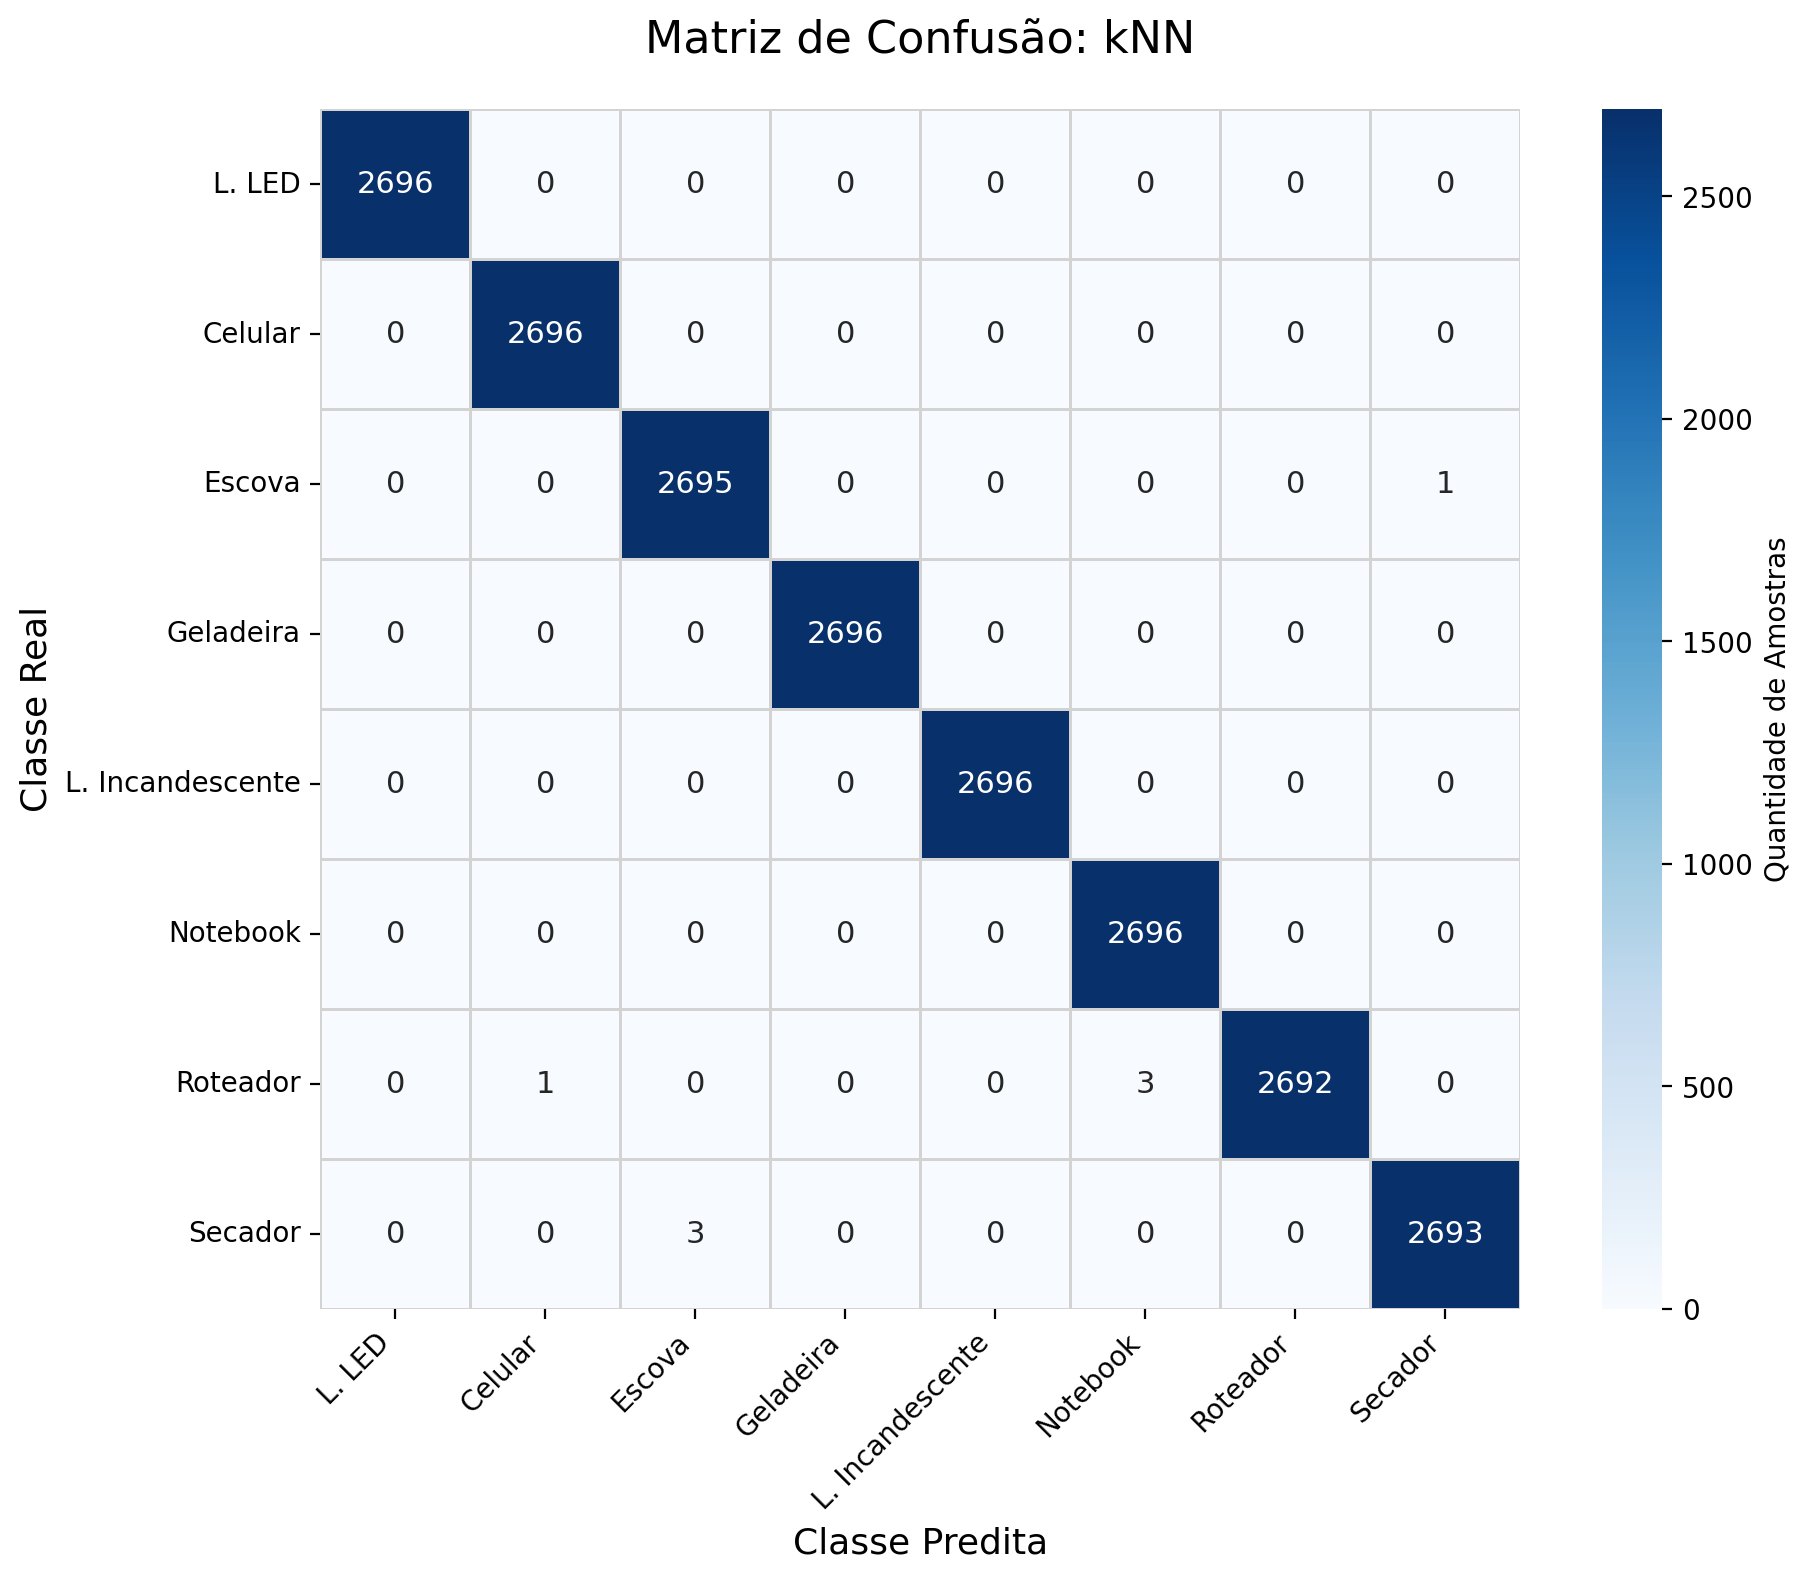

Imagem salva em: /content/matriz_confusao_knn.png


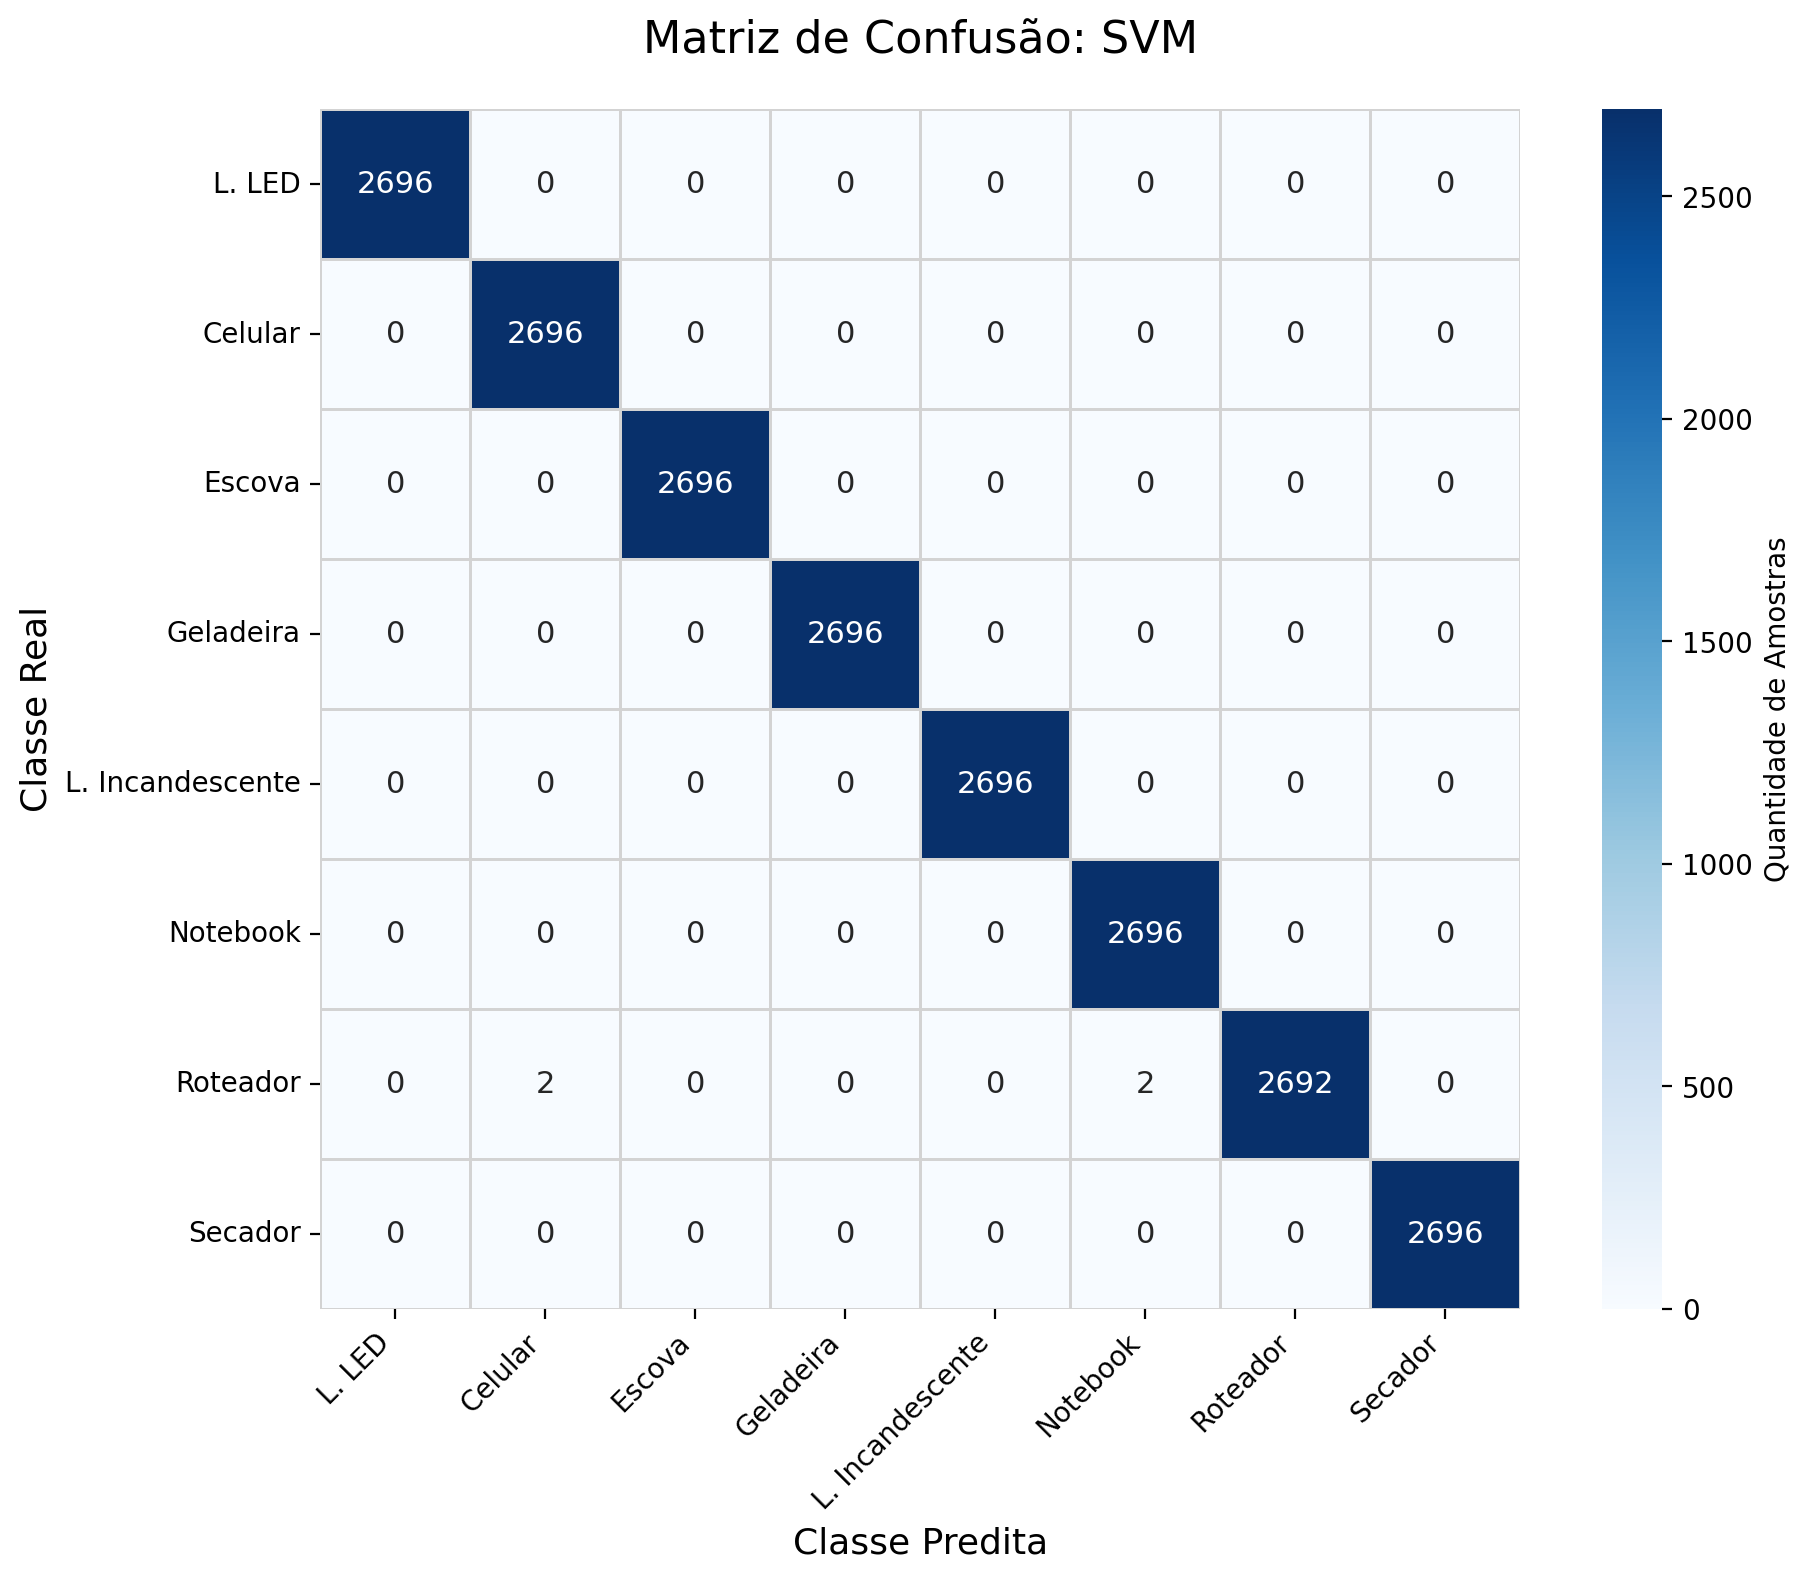

Imagem salva em: /content/matriz_confusao_svm.png


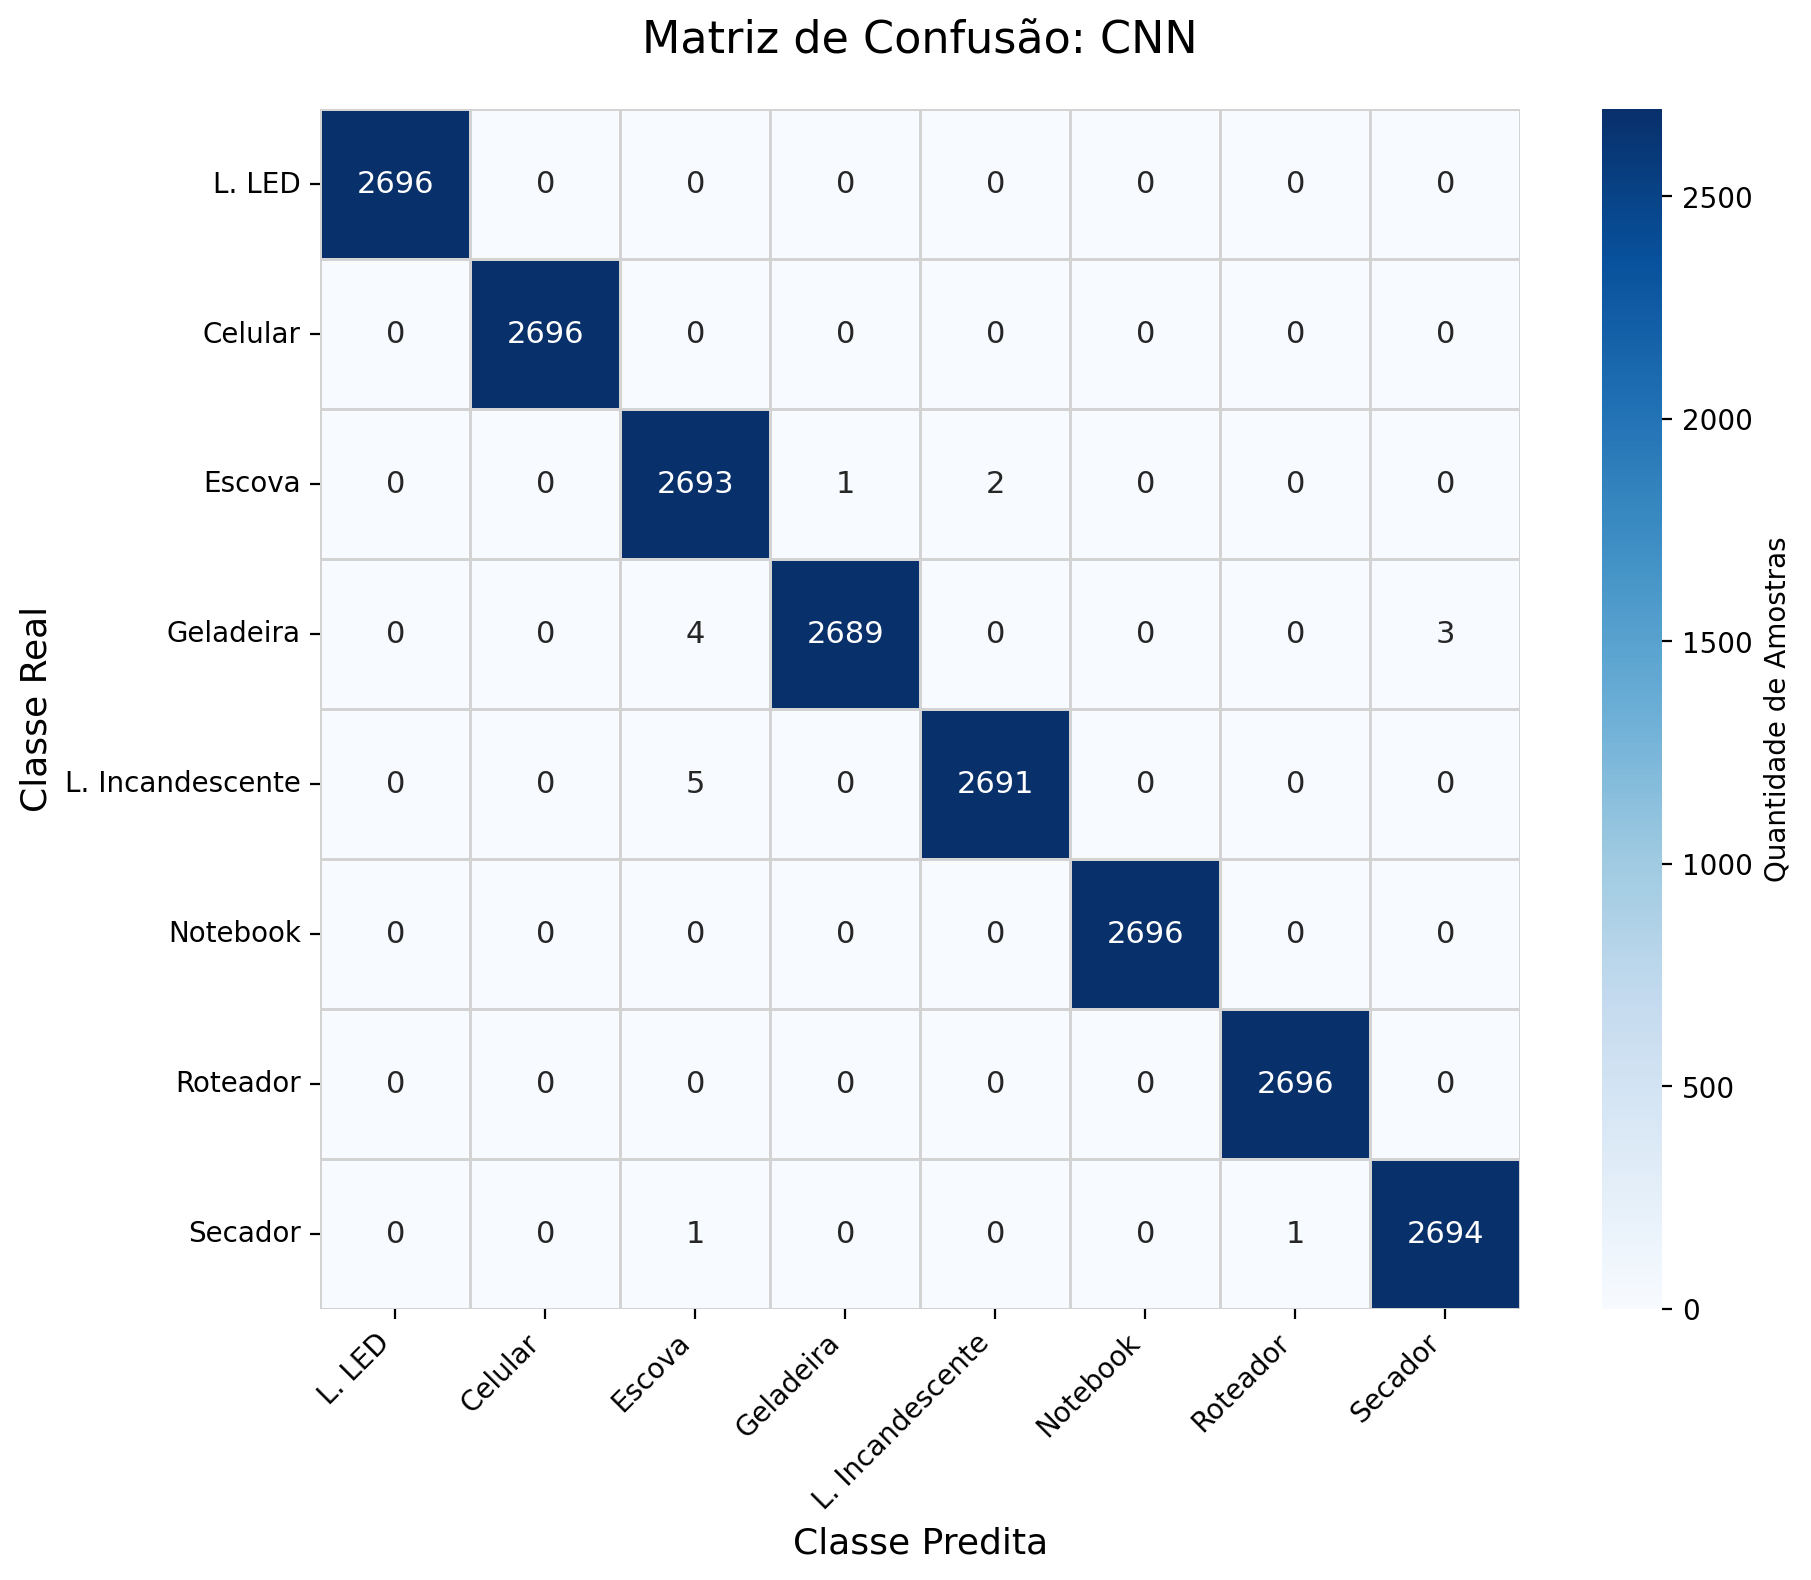

Imagem salva em: /content/matriz_confusao_cnn.png


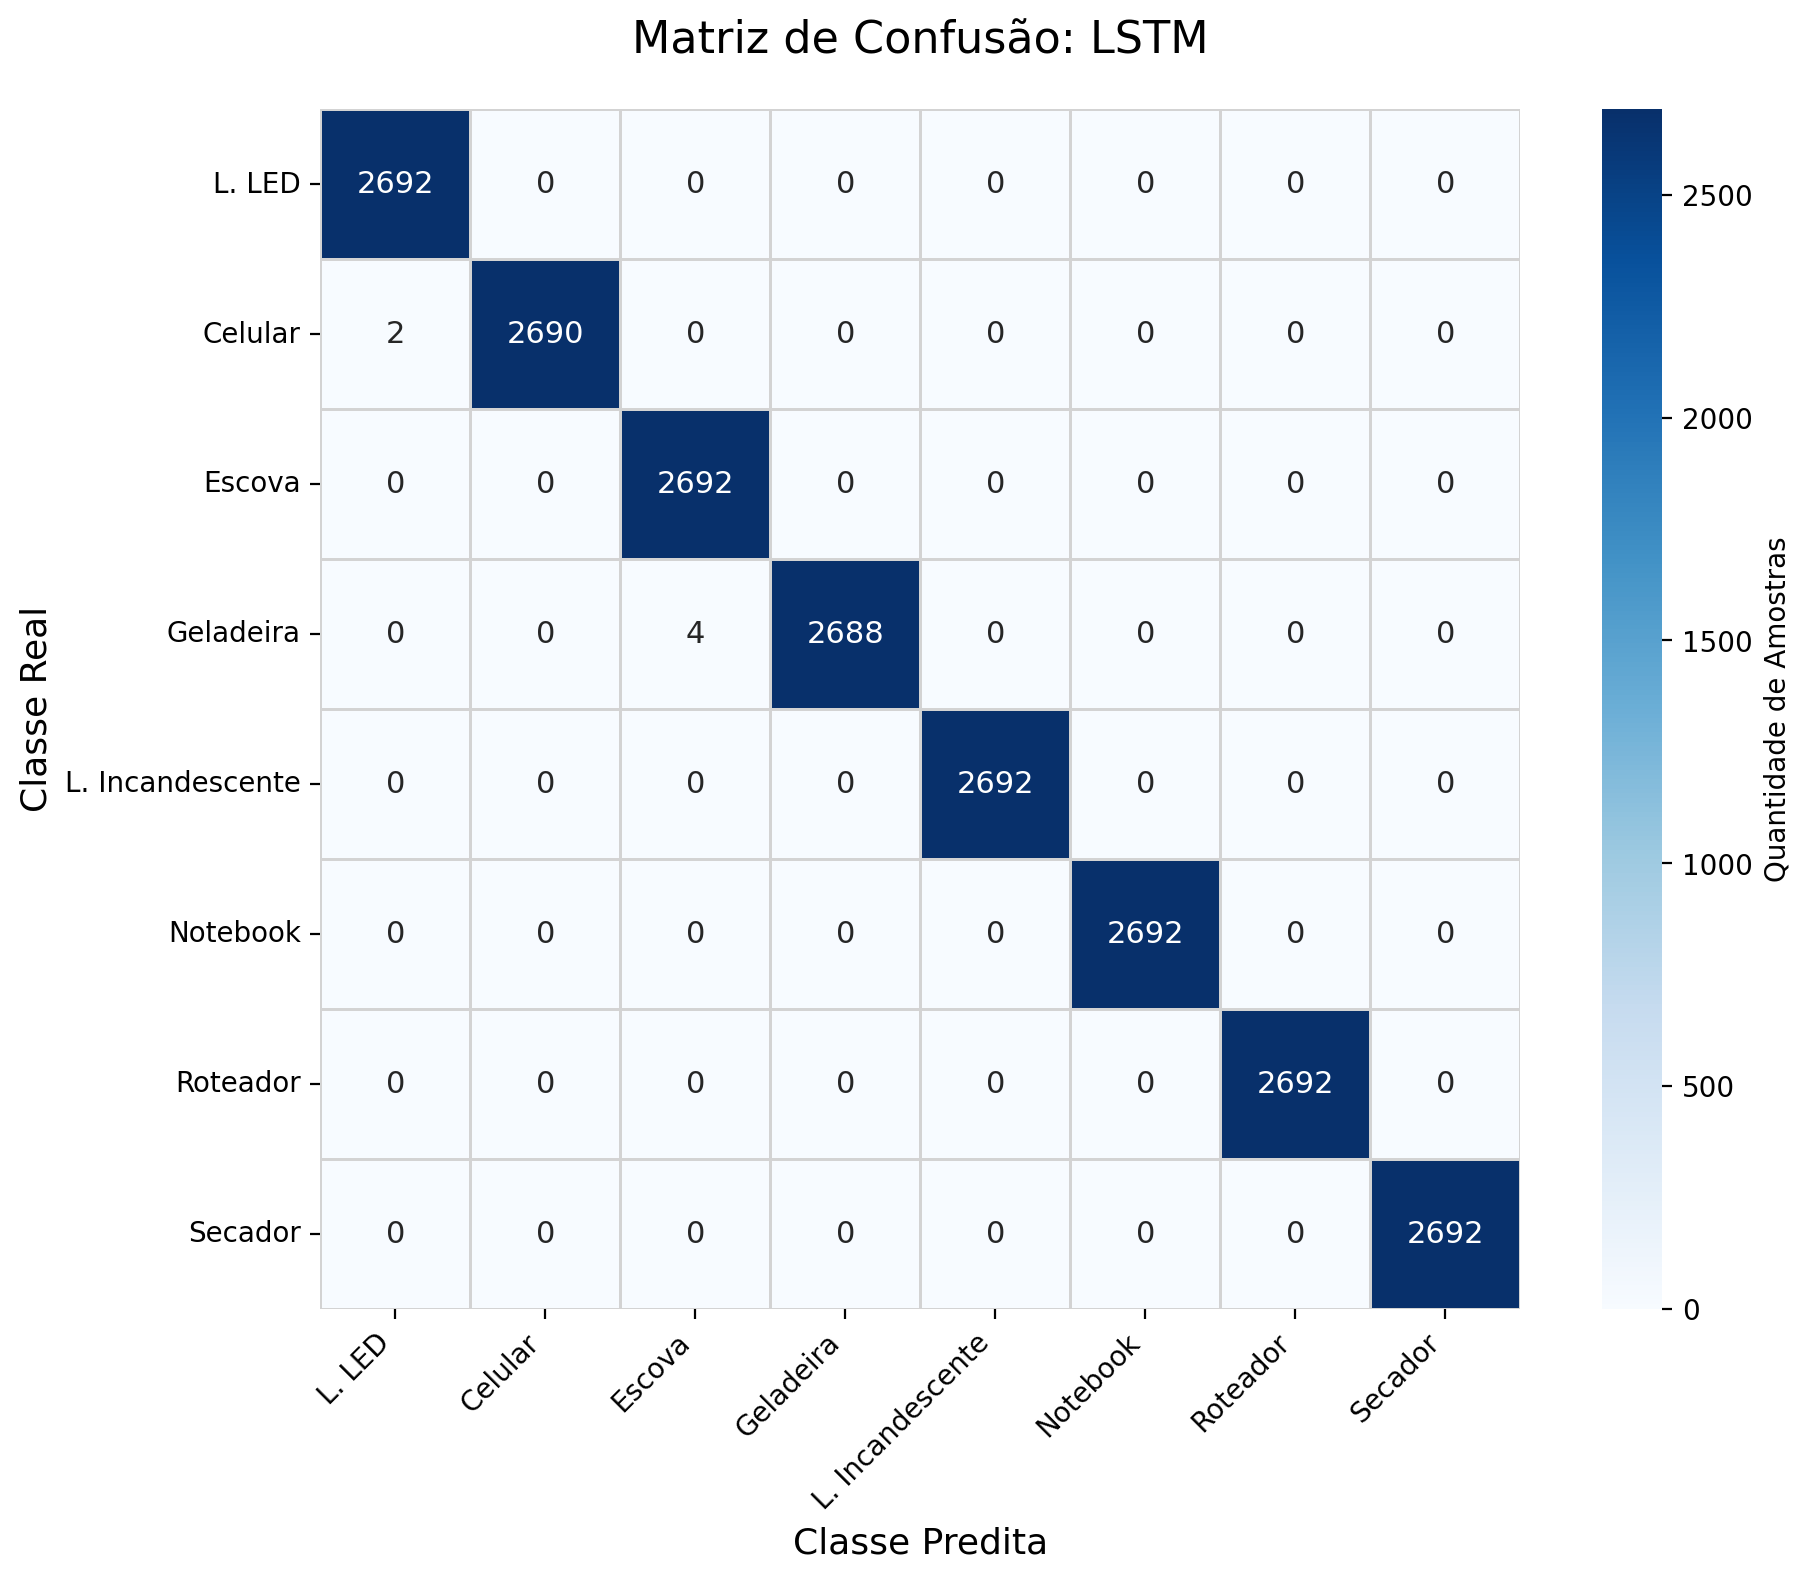

Imagem salva em: /content/matriz_confusao_lstm.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import os

# Configuração para alta definição no Colab
%config InlineBackend.figure_format = 'retina'

# 1. Definição das etiquetas
class_names_short = [
    'L. LED', 'Celular', 'Escova', 'Geladeira',
    'L. Incandescente', 'Notebook', 'Roteador', 'Secador'
]

def plot_custom_confusion_matrix(y_true, y_pred, model_name):
    """
    Gera a matriz com a mesma fonte do gráfico de barras, sem negrito.
    """
    # Cálculo da matriz
    cm = confusion_matrix(y_true, y_pred)

    # Resetar qualquer configuração de estilo anterior para usar o padrão do Matplotlib
    plt.rcParams.update(plt.rcParamsDefault)

    # Criar a figura (tamanho maior para garantir nitidez nos nomes)
    fig, ax = plt.subplots(figsize=(10, 8))

    # Gerando o Heatmap
    sns.heatmap(
        cm,
        annot=True,          # Mostra os números
        fmt='d',             # Inteiro
        cmap='Blues',        # Escala de azuis
        xticklabels=class_names_short,
        yticklabels=class_names_short,
        square=True,
        cbar_kws={'label': 'Quantidade de Amostras'},
        linewidths=0.5,
        linecolor='lightgrey',
        annot_kws={"size": 11} # NÚMEROS INTERNOS: SEM NEGRITO
    )

    # Títulos e eixos SEM NEGRITO (fontweight='normal')
    ax.set_title(f'Matriz de Confusão: {model_name}', fontsize=16, pad=20, fontweight='normal')
    ax.set_ylabel('Classe Real', fontsize=13, fontweight='normal')
    ax.set_xlabel('Classe Predita', fontsize=13, fontweight='normal')

    # Ajuste dos rótulos dos eixos (as classes)
    plt.xticks(rotation=45, ha='right', fontweight='normal')
    plt.yticks(rotation=0, fontweight='normal')

    plt.tight_layout()

    # Salvando em /content/ com alta resolução (300 DPI)
    caminho = f'/content/matriz_confusao_{model_name.lower()}.png'
    plt.savefig(caminho, dpi=300, bbox_inches='tight')

    plt.show()
    print(f"Imagem salva em: {caminho}")

# --- CHAMADAS ---
print("\n[INFO] Gerando matrizes com estilo padrão e sem negrito...")

try:
    # Substitua as variáveis abaixo pelas suas de teste e predição
    plot_custom_confusion_matrix(y_test, y_pred_knn, 'kNN')
    plot_custom_confusion_matrix(y_test, y_pred_svm, 'SVM')
    plot_custom_confusion_matrix(y_test, y_pred_cnn, 'CNN')
    plot_custom_confusion_matrix(y_test_lstm, y_pred_lstm, 'LSTM')
except NameError as e:
    print(f"[ERRO]: {e}. Rode o treino dos modelos primeiro.")

Acurácia kNN (%): 99.96290801186943
Acurácia SVM (%): 99.98145400593472
Acurácia CNN (%): 99.92117881774902
Acurácia LSTM (%): 99.97214078903198


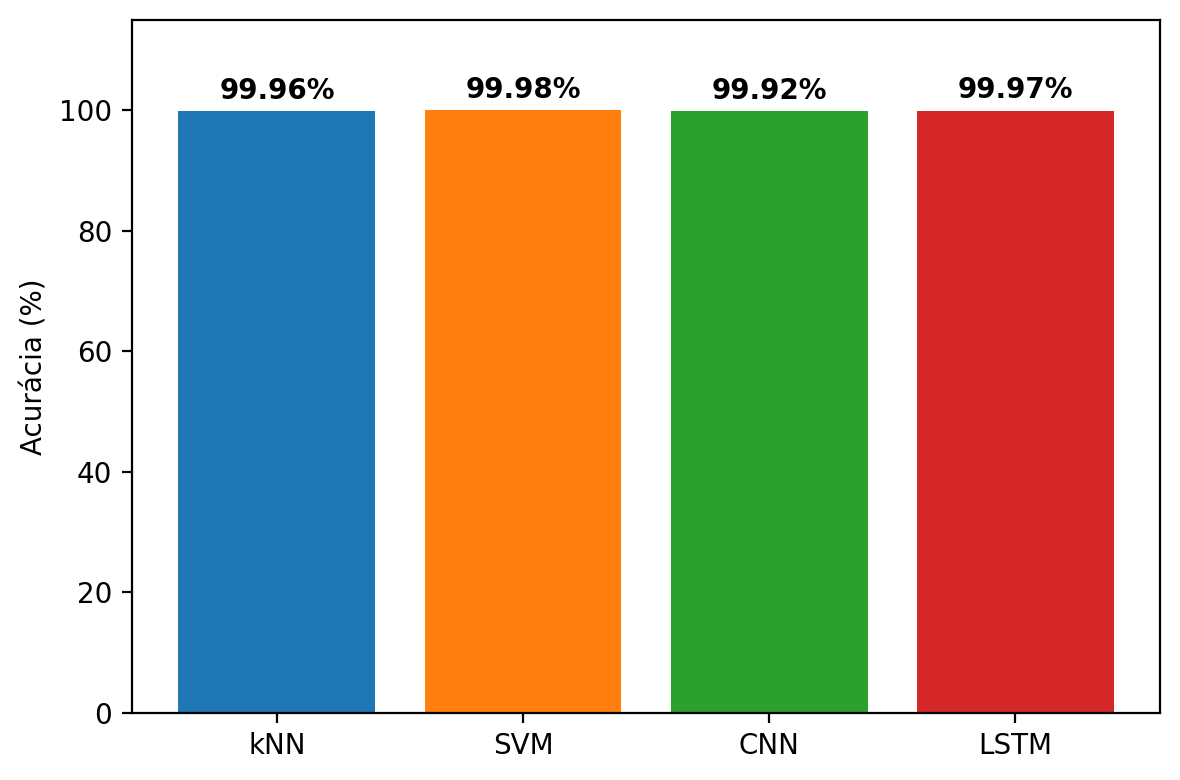

In [ ]:
import matplotlib.pyplot as plt

# Guarde as acurácias (Exemplo: 0.95 torna-se 95.0)
acc_knn  = accuracy_score(y_test,      y_pred_knn)
acc_svm  = accuracy_score(y_test,      y_pred_svm)
acc_cnn  = test_acc_cnn   # já vem de model.evaluate
acc_lstm = test_acc_lstm  # já vem de model.evaluate

# Lista com valores convertidos para porcentagem (* 100)
model_names = ['kNN', 'SVM', 'CNN', 'LSTM']
accuracies_pct  = [acc * 100 for acc in [acc_knn, acc_svm, acc_cnn, acc_lstm]]

print('Acurácia kNN (%):',  accuracies_pct[0])
print('Acurácia SVM (%):',  accuracies_pct[1])
print('Acurácia CNN (%):',  accuracies_pct[2])
print('Acurácia LSTM (%):', accuracies_pct[3])

plt.figure(figsize=(6, 4))
bars = plt.bar(model_names, accuracies_pct, color=['C0', 'C1', 'C2', 'C3'])

# Ajuste do limite Y para ir de 0 a 115 (dá espaço para o rótulo acima da barra)
plt.ylim(0, 115)
plt.ylabel('Acurácia (%)')
plt.title('')

# Mostrar valor em cima de cada barra com formatação de porcentagem
for i, v in enumerate(accuracies_pct):
    # v já está em porcentagem (ex: 95.5), formatamos com 2 casas decimais e o símbolo %
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
import os
import time
import psutil
import joblib
import gc
import numpy as np
import pandas as pd
from collections import Counter

# --- Funções de Apoio para Performance ---
def get_model_size_mb(model, name, is_keras):
    ext = ".keras" if is_keras else ".joblib"
    path = f"temp_{name.replace(' ', '_')}{ext}"
    try:
        if is_keras: model.save(path)
        else: joblib.dump(model, path)
        return os.path.getsize(path) / (1024 * 1024)
    finally:
        if os.path.exists(path): os.remove(path)

def classify_and_benchmark_final(path_csv):
    proc = psutil.Process(os.getpid())
    def get_cpu_time(): return float(proc.cpu_times().user + proc.cpu_times().system)
    def get_rss_mb(): return proc.memory_info().rss / (1024**2)

    print(f'\n[INICIANDO] Arquivo: {path_csv}')
    metrics = []
    results_preds = {}

    # 1) PRÉ-PROCESSAMENTO (Exatamente como no seu código que funciona)
    t0_pre = time.perf_counter()

    # Lendo especificamente a segunda coluna (Corrente)
    df = pd.read_csv(path_csv, header=0, usecols=[1])
    data = df.iloc[:, 0].astype(float).values

    wins = window_signal(data, window_size, step)
    if wins.shape[0] == 0:
        print('Arquivo muito curto.')
        return None

    # Features para kNN/SVM
    feats = extract_features_from_windows(wins, fs, n_harmonics)
    X_new_knn = scaler_tf.transform(feats)

    # Dados para CNN
    wins_norm = normalize_windows_per_sample(wins)
    X_new_cnn = wins_norm[..., np.newaxis]

    # Dados para LSTM
    dummy_labels = np.zeros(wins.shape[0], dtype=int)
    X_new_seq, _ = build_sequences(wins_norm, dummy_labels, L_seq)

    t_pre_ms = (time.perf_counter() - t0_pre) * 1000
    print(f"Pré-processamento concluído em: {t_pre_ms:.2f} ms")

    # 2) LOOP DE BENCHMARK (kNN, SVM, CNN, LSTM)
    # Lista de tuplas: (objeto_modelo, input, nome, é_keras)
    model_configs = [
        (knn,        X_new_knn, "kNN",    False),
        (svm_clf,    X_new_knn, "SVM",    False),
        (cnn_model,  X_new_cnn, "CNN 1D", True),
        (lstm_model, X_new_seq, "LSTM",   True)
    ]

    for model, x_input, name, is_keras in model_configs:
        if x_input is None or len(x_input) == 0: continue

        # Tamanho do Modelo
        size_mb = get_model_size_mb(model, name, is_keras)

        # Warm-up
        _ = model.predict(x_input[:1], verbose=0) if is_keras else model.predict(x_input[:1])

        gc.collect()
        rss0 = get_rss_mb()
        cpu0 = get_cpu_time()
        t0 = time.perf_counter()

        # INFERÊNCIA REAL
        if is_keras:
            probs = model.predict(x_input, verbose=0)
            p_int = np.argmax(probs, axis=1)
        else:
            p_int = model.predict(x_input)

        wall_s = time.perf_counter() - t0
        cpu_s = get_cpu_time() - cpu0
        rss1 = get_rss_mb()

        results_preds[name] = p_int

        metrics.append({
            "Modelo": name,
            "Tamanho (MB)": round(size_mb, 4),
            "Latência Total (ms)": round(wall_s * 1000, 2),
            "Média/Janela (ms)": round((wall_s * 1000) / len(x_input), 4),
            "Carga CPU (%)": round((cpu_s / wall_s) * 100, 2) if wall_s > 0 else 0,
        })

    # 3) RESULTADOS DE CLASSIFICAÇÃO (Voto Majoritário)
    class_names = le.classes_
    print('\n--- Resultados da Classificação ---')
    for name, preds in results_preds.items():
        maj_idx = Counter(preds).most_common(1)[0][0]
        print(f'{name:6}: {class_names[maj_idx]}')

    return pd.DataFrame(metrics)

# --- EXECUÇÃO ---
df_perf = classify_and_benchmark_final('dados_tempo_notebook_ufc.csv')

if df_perf is not None:
    print("\n--- Tabela de Performance Computacional ---")
    print(df_perf.to_string(index=False))

In [ ]:
import numpy as np
from collections import Counter

# Lista dos seus arquivos
arquivos = ['celular_ufc.csv', 'lampada_incadecente_ufc.csv', 'notebook_ufc.csv']

print(f"{'Arquivo':<30} | {'Modelo':<6} | {'Predição':<20} | {'Confiança'}")
print("-" * 85)

for path in arquivos:
    result = classify_new_file(path)

    if result is None:
        continue

    # Extração dos dados do dicionário
    class_names = result['class_names']

    # Dicionário para iterar sobre os resultados
    modelos_preds = {
        'kNN':  result['preds_knn'],
        'SVM':  result['preds_svm'],
        'CNN':  result['preds_cnn'],
        'LSTM': result['preds_lstm']
    }

    # Probabilidades para os modelos de Deep Learning
    probs_dl = {
        'CNN':  result['probs_cnn'],
        'LSTM': result['probs_lstm']
    }

    for nome_modelo, preds in modelos_preds.items():
        if preds is None or len(preds) == 0:
            print(f"{path:<30} | {nome_modelo:<6} | {'Erro/Curto':<20} | ---")
            continue

        # 1. Determinar classe majoritária
        contagem = Counter(preds)
        idx_majoritario, frequencia = contagem.most_common(1)[0]
        label_final = class_names[idx_majoritario]

        # 2. Calcular a Certeza (Confiança)
        if nome_modelo in ['CNN', 'LSTM']:
            # Média da probabilidade da classe escolhida em todas as janelas/sequências
            prob_media = np.mean(np.max(probs_dl[nome_modelo], axis=1)) * 100
            certeza_str = f"{prob_media:.2f}% (softmax)"
        else:
            # Consistência: % de janelas que votaram na classe majoritária
            consistencia = (frequencia / len(preds)) * 100
            certeza_str = f"{consistencia:.2f}% (votação)"

        print(f"{path:<30} | {nome_modelo:<6} | {label_final:<20} | {certeza_str}")

Arquivo                        | Modelo | Predição             | Confiança
-------------------------------------------------------------------------------------

Classificando novo arquivo: celular_ufc.csv
celular_ufc.csv                | kNN    | celular              | 60.14% (votação)
celular_ufc.csv                | SVM    | celular              | 100.00% (votação)
celular_ufc.csv                | CNN    | celular              | 97.99% (softmax)
celular_ufc.csv                | LSTM   | celular              | 94.33% (softmax)

Classificando novo arquivo: lampada_incadecente_ufc.csv
lampada_incadecente_ufc.csv    | kNN    | lamp_aquecimento     | 100.00% (votação)
lampada_incadecente_ufc.csv    | SVM    | lamp_aquecimento     | 100.00% (votação)
lampada_incadecente_ufc.csv    | CNN    | lamp_aquecimento     | 99.95% (softmax)
lampada_incadecente_ufc.csv    | LSTM   | lamp_aquecimento     | 99.96% (softmax)

Classificando novo arquivo: notebook_ufc.csv
notebook_ufc.csv               |

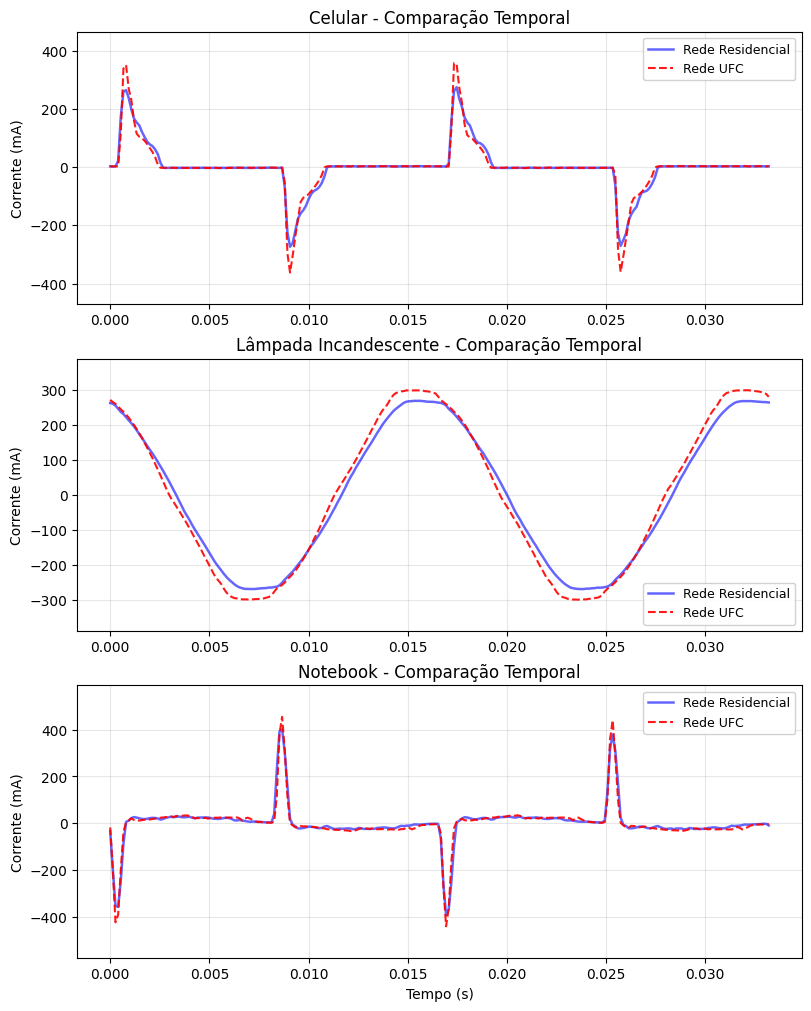

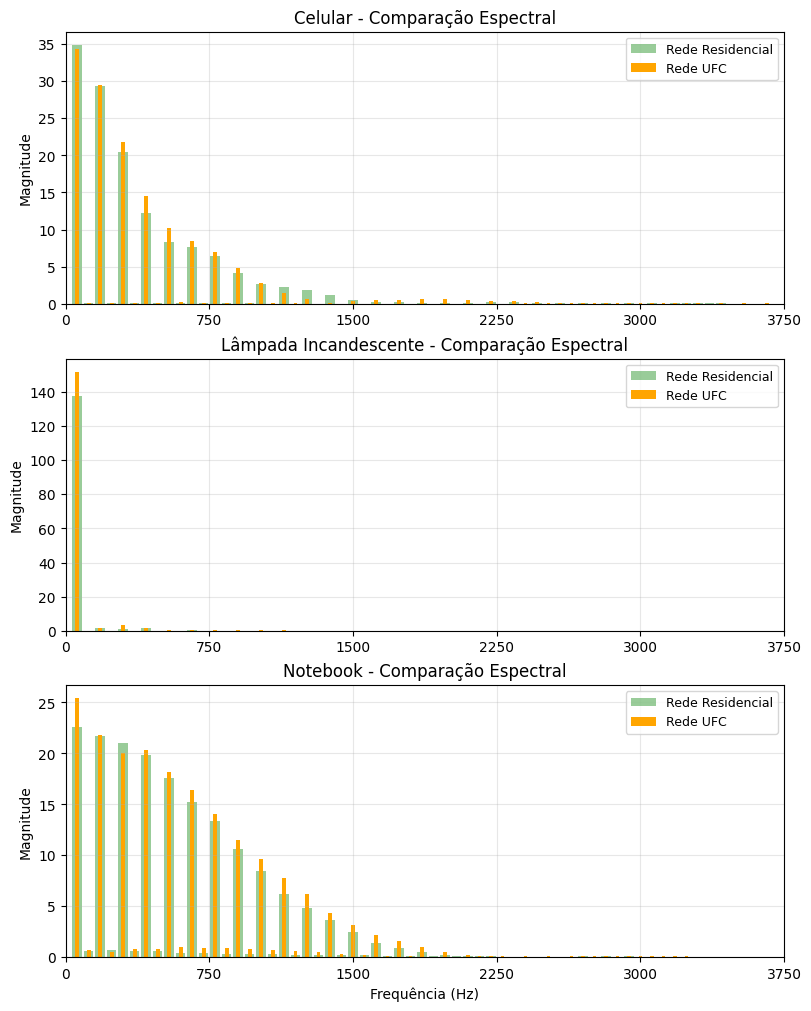

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate

# =============================================================================
# FUNÇÕES
# =============================================================================

def alinhar_sinais(sinal_ref, sinal_alvo):
    s1 = sinal_ref - np.mean(sinal_ref)
    s2 = sinal_alvo - np.mean(sinal_alvo)
    corr = correlate(s1, s2, mode='full')
    lag = np.argmax(corr) - (len(sinal_alvo) - 1)
    return np.roll(sinal_alvo, lag)

def get_data_tempo(path_csv, fs, t_min=0.10):
    try:
        df = pd.read_csv(path_csv, header=0)
        try:
            corrente = df.iloc[:, 1].astype(float).values
        except:
            corrente = df['corrente'].astype(float).values

        N = min(len(corrente), fs)
        corrente = corrente[:N]
        ciclos_pts = int(2 * fs / 60)

        if len(corrente) < ciclos_pts: y = corrente
        else: y = corrente[:ciclos_pts]

        t = np.arange(len(y)) / fs
        return t, y
    except: return None, None

def get_data_freq(path_csv, fs):
    try:
        df = pd.read_csv(path_csv, header=0)
        try:
            corrente = df.iloc[:, 1].astype(float).values
        except:
            corrente = df['corrente'].astype(float).values

        N = min(len(corrente), fs)
        corrente = corrente[:N]
        fft_vals = np.fft.rfft(corrente)
        mag = np.abs(fft_vals) / N
        freqs = np.fft.rfftfreq(N, d=1/fs)

        f_rede = 60.0
        max_freq = 3750.0
        harm = np.arange(f_rede, max_freq + f_rede, f_rede)
        harm = harm[harm <= max_freq]

        idx = [np.argmin(np.abs(freqs - fh)) for fh in harm]
        return harm, mag[idx], max_freq
    except: return None, None, None

# =============================================================================
# CONFIGURAÇÃO
# =============================================================================

comparacoes = {
    'Celular': ['celular_tempo.csv', 'celular_ufc.csv'],
    'Lâmpada Incandescente': ['lamp_aquecimento_tempo.csv', 'lampada_incadecente_ufc.csv'],
    'Notebook': ['notebook_tempo.csv', 'notebook_ufc.csv']
}

fs = 7500
dispositivos = list(comparacoes.keys())
n_rows = len(dispositivos)

# =============================================================================
# 1. TEMPO (SOBREPOSTO) - COM CORREÇÃO DE LEGENDA
# =============================================================================

fig, axes = plt.subplots(n_rows, 1, figsize=(8, 10), constrained_layout=True)

for i, dispositivo in enumerate(dispositivos):
    arquivo_ds, arquivo_ufc = comparacoes[dispositivo]
    ax = axes[i]

    t_ds, y_ds = get_data_tempo(arquivo_ds, fs)
    t_ufc, y_ufc_raw = get_data_tempo(arquivo_ufc, fs)

    if t_ds is not None and y_ufc_raw is not None:
        min_len = min(len(y_ds), len(y_ufc_raw))
        y_ds = y_ds[:min_len]
        y_ufc = alinhar_sinais(y_ds, y_ufc_raw[:min_len])
        t = t_ds[:min_len]

        # Plotagem
        ax.plot(t, y_ds, color='blue', linewidth=1.8, label='Rede Residencial', alpha=0.6)
        ax.plot(t, y_ufc, color='red', linewidth=1.5, linestyle='--', label='Rede UFC', alpha=0.9)

        ax.set_title(f'{dispositivo} - Comparação Temporal', fontsize=12, fontweight='normal')
        ax.grid(True, alpha=0.3)
        ax.set_ylabel('Corrente (mA)', fontsize=10)
        ax.margins(y=0.15)

        # --- LÓGICA ESPECIAL PARA A LEGENDA DA LÂMPADA ---
        if 'Lâmpada' in dispositivo:
            ax.legend(loc='lower right', fontsize=9, framealpha=0.9)
        else:
            # Padrão para os outros
            ax.legend(loc='upper right', fontsize=9, framealpha=0.9)

        if i == n_rows - 1:
            ax.set_xlabel('Tempo (s)', fontsize=10)
    else:
        ax.text(0.5, 0.5, 'Dados não encontrados', ha='center')

plt.savefig('comparacao_tempo_sobreposto.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 2. FREQUÊNCIA (SOBREPOSTO)
# =============================================================================

fig, axes = plt.subplots(n_rows, 1, figsize=(8, 10), constrained_layout=True)

for i, dispositivo in enumerate(dispositivos):
    arquivo_ds, arquivo_ufc = comparacoes[dispositivo]
    ax = axes[i]

    harm_ds, mag_ds, max_f = get_data_freq(arquivo_ds, fs)
    harm_ufc, mag_ufc, _ = get_data_freq(arquivo_ufc, fs)

    if harm_ds is not None and harm_ufc is not None:
        ax.bar(harm_ds, mag_ds, width=50, color='green', alpha=0.4, label='Rede Residencial')
        ax.bar(harm_ufc, mag_ufc, width=20, color='orange', alpha=1.0, label='Rede UFC')

        ax.set_xlim(0, max_f)
        xticks = np.linspace(0, max_f, 6)
        ax.set_xticks(xticks)

        ax.set_title(f'{dispositivo} - Comparação Espectral', fontsize=12, fontweight='normal')
        ax.grid(True, alpha=0.3)
        ax.set_ylabel('Magnitude', fontsize=10)
        ax.legend(loc='upper right', fontsize=9)

        if i == n_rows - 1:
            ax.set_xlabel('Frequência (Hz)', fontsize=10)
    else:
        ax.text(0.5, 0.5, 'Dados não encontrados', ha='center')

plt.savefig('comparacao_freq_sobreposto.png', dpi=300, bbox_inches='tight')
plt.show()
